In [1]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils 


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 92
STIM_SIGMA = 0.075
BATCH_SIZE = 128

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

In [2]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)



In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path())

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_cpn = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

loader_en = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


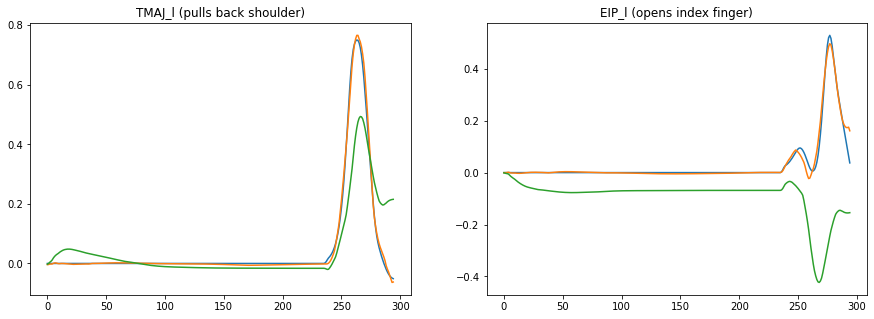

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].detach().numpy())

plt.show()

tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0207, grad_fn=<MseLossBackward>)


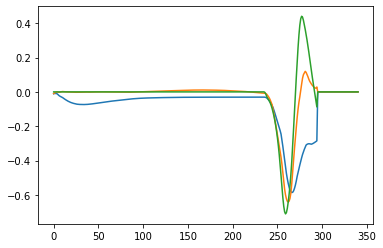

In [6]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].detach().numpy())
plt.plot(dout[0, :, 20].detach().numpy())
plt.show()


In [5]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim
    
    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
        new_obs_en = torch.tensor(obs[0]).float()

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs_en, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])
    return actuals, preds, stims 

In [10]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None):
    # the last EN we were working on training, for easy access
    global recent_en
    
    obs_dim = observer.out_dim * 1
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None:
        en = stim_model.StimModelLSTM(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim+30, activation_func=torch.nn.Tanh)
        recent_en = en
    vl = torch.tensor(1.0)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.04)
    
    cpn_reset_cadence = 10


    checkpoint_eidx = 0
    eidx = -1
    while True:
        
        for batch in data_loader:            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            eidx += 1
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            
            for p in opt_en.param_groups:
                #if eidx < 3:
                #    p['lr'] = 2e-2
                #else:
                if vl.item() < 0.0007:
                    p['lr'] = 1e-4
                elif vl.item() < 0.005:
                    p['lr'] = 3e-3
                else:
                    p['lr'] = 9e-3
            
            if (eidx % cpn_reset_cadence) == 0:
                cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(last_loss))
                opt_cpnn = AdamW(cpn_noise.parameters(), lr=1e-4)
            else:
                opt_cpnn.zero_grad()
                cpn_noise.reset()

        
            # Just in case...
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx)
            
            # Update our noisy cpn
            target_loss = loss(preds, dout[:, 1:, :])
            target_loss.backward(retain_graph=True)
            opt_cpnn.step()
            opt_en.zero_grad()
        
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()
        
            # Verify against the actual CPN
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                              trial_end, observer,
                                              drop_module_idx=drop_module_idx)
           
            vl = loss(preds_val, actual_val)
            print("en", eidx, rl.item(), "val:", vl.item())
                    
            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModelLSTM(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)
                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.02)
                checkpoint_eidx = eidx
                
            if vl.item() < max(0.05 * last_loss, 0.0007) and eidx > 100:
                done = True
                break
            else:
                done = False
                
        if done:
            break
            
    opt_en.zero_grad()
    return en

In [ ]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
                             num_neurons=100, activation_func=torch.nn.Tanh)

#cpn.load_state_dict(torch.load('bmin_cpn_F5condrop_obs20_stim92'))

# Up to 0.001:
opt_cpn = AdamW(cpn.parameters(), lr=1e-4)

# 0.0007
#opt_cpn = AdamW(cpn.parameters(), lr=1e-5)

#opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

loss = torch.nn.MSELoss()
rli = 1

cpn_losses = []
pred_losses = []
real_losses = []
super_epoch_count = 0
en = None

while True:       
    super_epoch_count += 1
    
    for param in cpn.parameters():
        param.requires_grad=False
    
    #if super_epoch_count > 1:
    en = train_an_en(mike, observer, cpn, loader_en, last_loss=rli)
    
    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False
    
        
    recent_losses = []
    eidx = -1
    while eidx < 5000:
        for batch in loader_cpn:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()
            
            if rli > 0.02:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-4
            elif rli <= 0.015:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-5
            elif rli <= 0.012:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-6
            elif rli <= 0.01:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-6
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
    
            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           retain_stim_grads=True)
            preds.retain_grad()
            
            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  
            
            cpn_losses.append(rli)

            real_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :]).item()
            real_losses.append(real_loss)
                        
            pred_loss = torch.nn.MSELoss()(preds, actuals).item()
            pred_losses.append(pred_loss)
            
            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss)
            recent_losses.append(real_loss)
            
            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim92")
            torch.save(en.state_dict(), "latest_en")
            if real_loss == min(recent_losses) and real_loss < 0.01:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim92")
                                                          
            bail = False
            done = False
            # Emergency bailout; time to retrain en
            if len(recent_losses) > 4 and (recent_losses[-1] > recent_losses[0] * 1.2):
                bail = True
                break
            # Done
            elif rli < 1e-5:
                bail = True
                done = True
                break
            elif len(recent_losses) > 7:
                prev = None
                num_regressed = 0
                for l in recent_losses[-7:]:
                    if prev is not None and l > prev:
                        num_regressed += 1
                        
                prev = l
                if num_regressed > 3 or pred_loss > max(real_loss / 10, 9e-4):
                    bail = True
                    break
              
                
            opt_cpn.step()
                
            if bail:
                break
                
        if bail:
            break
            
    if done:
        break


# Best with trial ends not trunc'd 0.0076


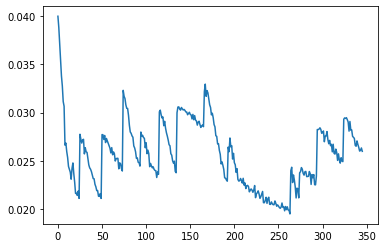

0.019490566104650497


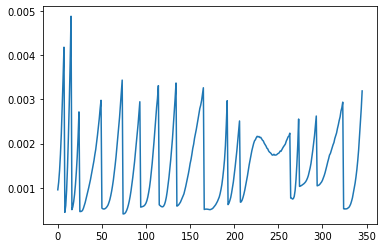

0.0004137098731007427


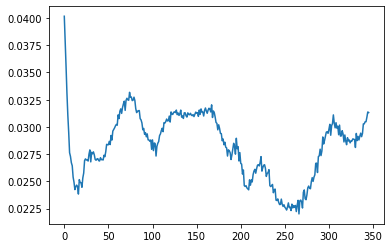

0.022017227485775948
-0.07298790498179297 tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MseLossBackward>)


In [10]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.show()
print(min(real_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [ ]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

torch.Size([1, 341, 50])


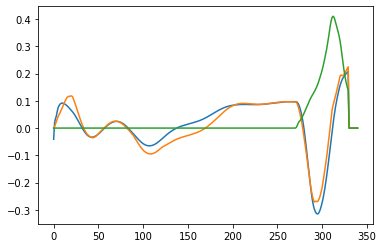

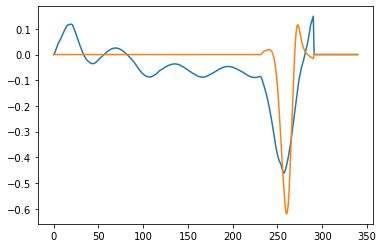

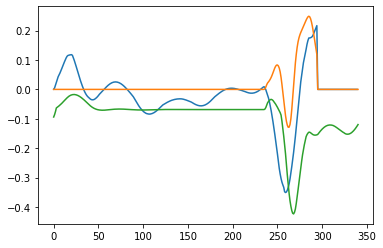

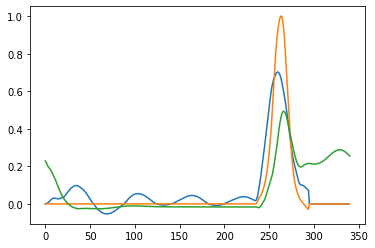

In [69]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

print(reference_pred_lesioned_0.shape)


plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
#plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

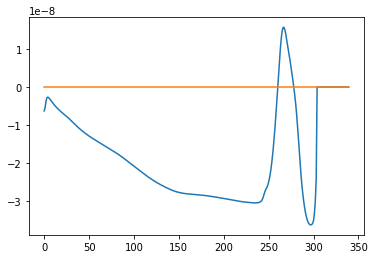

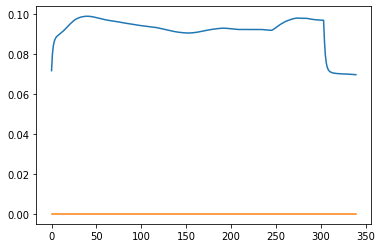

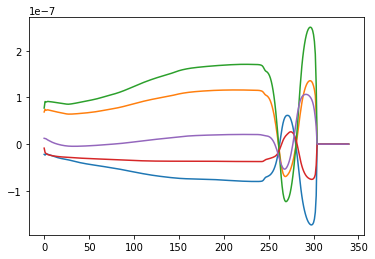

In [44]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

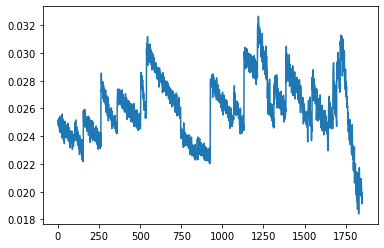

In [12]:
plt.plot(cpn_losses)